In [6]:

!pip install keras_vggface
!pip install keras_applications

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image_dataset
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D

     |████████████████████████████████| 51kB 6.6MB/s 


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip "/content/drive/MyDrive/Colab Notebooks/dataset2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset2/train/angry/Training_43689799.jpg  
  inflating: __MACOSX/dataset2/train/angry/._Training_43689799.jpg  
  inflating: dataset2/train/angry/Training_27994003.jpg  
  inflating: __MACOSX/dataset2/train/angry/._Training_27994003.jpg  
  inflating: dataset2/train/angry/Training_94377760.jpg  
  inflating: __MACOSX/dataset2/train/angry/._Training_94377760.jpg  
  inflating: dataset2/train/angry/Training_64774028.jpg  
  inflating: __MACOSX/dataset2/train/angry/._Training_64774028.jpg  
  inflating: dataset2/train/angry/Training_29632995.jpg  
  inflating: __MACOSX/dataset2/train/angry/._Training_29632995.jpg  
  inflating: dataset2/train/angry/Training_52746871.jpg  
  inflating: __MACOSX/dataset2/train/angry/._Training_52746871.jpg  
  inflating: dataset2/train/angry/Training_15484575.jpg  
  inflating: __MACOSX/dataset2/train/angry/._Training_15484575.jpg  
  inflating: dataset2/train/angry/Training_55480975.jpg  
  

In [9]:
EPOCHS = 120
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.001
SGD_DECAY = 0.0001

Model Initialization


leave the weights of the feature extraction layers unchanged, only train on the weights of the fully connected and final classification layer

In [11]:
vgg_model = VGGFace(model="vgg16", include_top=False, input_shape=(197,197,3),pooling="avg")
# print(vgg_model.summary())

last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_model.layers[i].trainable = False

print(vgg_model.get_layer('pool5').trainable)

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_model.input, out)
print(model.summary())

# optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optim = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode="max", factor=0.5,
                              patience=10, min_lr=0.00001, verbose=1)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

58916864/58909280 [==============================] - 1s 0us/step
False
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 197, 197, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
_________________________________________________

load in preprocessed data

In [ ]:
'''
def load_data(train_path, test_path,aug=False):
    if aug:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            validation_split=0.2)
      
        train_generator = train_datagen.flow_from_directory(
            directory=train_path,
            class_mode="categorical",
            target_size=(48,48),
            batch_size=BS,
            shuffle=True,
            seed=1337,
            subset='training'
            )
        valid_generator = train_datagen.flow_from_directory(
            directory=train_path,
            class_mode="categorical",
            target_size=(48,48),
            batch_size=BS,
            shuffle=True,
            seed=1337,
            subset='validation'
        )

    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255)
        train_data = train_datagen.flow_from_directory(
                directory=train_path, 
                label_mode='categorical',
                batch_size=BS,
                image_size=(48, 48), 
                shuffle=True, 
                seed=1337,
                validation_split=0.2,
                subset="training")
        val_data = image_dataset.image_dataset_from_directory(
                directory=train_path, 
                label_mode='categorical',
                batch_size=BS,
                image_size=(48, 48), 
                shuffle=True, 
                seed=1337,
                validation_split=0.2,
                subset="validation")
    test_datagen = ImageDataGenerator(
            rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
            directory=test_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(48, 48), 
            shuffle=True)
    return train_generator, valid_generator, test_generator

# configuration for better performance
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
# valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)
train_generator, valid_generator, test_generator = load_data("dataset2/train", "dataset2/test",True)
'''

In [13]:
def load_data(train_path, test_path):
    train_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(197, 197), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="training")
    val_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(197, 197), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="validation")
    test_data = image_dataset.image_dataset_from_directory(
            test_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(197, 197), 
            shuffle=True)
    return train_data, val_data, test_data


train_data, valid_data, test_data = load_data("dataset2/train", "dataset2/test")

Found 22035 files belonging to 7 classes.
Using 17628 files for training.
Found 22035 files belonging to 7 classes.
Using 4407 files for validation.
Found 5512 files belonging to 7 classes.


In [14]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[reduce_lr]
    )

Epoch 1/120
138/138 [==============================] - 91s 657ms/step - loss: 24.4919 - accuracy: 0.3182 - val_loss: 1.4199 - val_accuracy: 0.4774
Epoch 2/120
138/138 [==============================] - 89s 646ms/step - loss: 1.4511 - accuracy: 0.4436 - val_loss: 1.3128 - val_accuracy: 0.4491
Epoch 3/120
138/138 [==============================] - 93s 673ms/step - loss: 1.3700 - accuracy: 0.4756 - val_loss: 1.2179 - val_accuracy: 0.5391
Epoch 4/120
138/138 [==============================] - 95s 685ms/step - loss: 1.2884 - accuracy: 0.5170 - val_loss: 1.1591 - val_accuracy: 0.5745
Epoch 5/120
138/138 [==============================] - 94s 682ms/step - loss: 1.2376 - accuracy: 0.5427 - val_loss: 1.1357 - val_accuracy: 0.5754
Epoch 6/120
138/138 [==============================] - 94s 682ms/step - loss: 1.2033 - accuracy: 0.5542 - val_loss: 1.1062 - val_accuracy: 0.5952
Epoch 7/120
138/138 [==============================] - 95s 685ms/step - loss: 1.1771 - accuracy: 0.5689 - val_loss: 1.1039 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


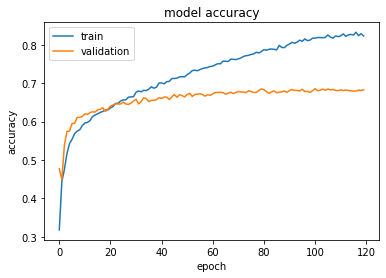

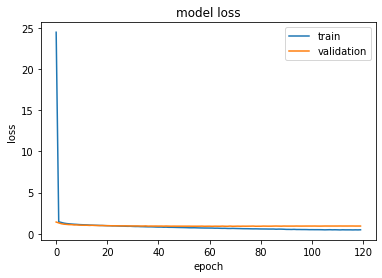

In [15]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
# plt.savefig('/content/drive/MyDrive/701 project/results/VGG16_dense1024_sgd' + epoch_str + dropout_str + '-accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
# plt.savefig('/content/drive/MyDrive/701 project/results/VGG16_dense1024_sgd' + epoch_str + dropout_str + '-loss.png')
plt.show()

In [16]:
print('\n# Evaluate on validation data')
results_val = model.evaluate(valid_data, batch_size=BS)
print('validation loss, validation accuracy:', results_val)


# Evaluate on validation data
35/35 [==============================] - 17s 496ms/step - loss: 0.9318 - accuracy: 0.6830
validation loss, validation accuracy: [0.9318137168884277, 0.6830043196678162]


In [17]:
print('\n# Evaluate on test data')
results_test = model.evaluate(test_data, batch_size=BS)
print('test loss, test accuracy:', results_test)


# Evaluate on test data
44/44 [==============================] - 22s 510ms/step - loss: 0.9335 - accuracy: 0.6831
test loss, test accuracy: [0.9334797263145447, 0.6830551624298096]


In [18]:
test_acc = '-test_acc_%.3f' % results_test[1]
model.save('/content/drive/MyDrive/Colab Notebooks/VGG16_sgd_' + epoch_str + dropout_str + test_acc + '.h5')